### **STEP 1: Librerie**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
import pandas as pd
from sklearn.utils import resample

# Carica dataset
df = pd.read_csv("/content/drive/MyDrive/IATOARTS/features_combined2.csv")

# Rimuovi eventuali sample di testing
df = df[~df['audio_path'].str.contains("/testing")]

# Controlla la distribuzione iniziale
class_counts = df['label'].value_counts()
print("Distribuzione originale:\n", class_counts)

# Definisci la soglia minima di campioni per classe
MIN_SAMPLES = 10

# Oversampling manuale
df_balanced = pd.DataFrame()
for label, count in class_counts.items():
    df_class = df[df['label'] == label]
    if count < MIN_SAMPLES:
        df_upsampled = resample(df_class, replace=True, n_samples=MIN_SAMPLES, random_state=42)
        df_balanced = pd.concat([df_balanced, df_upsampled])
    else:
        df_balanced = pd.concat([df_balanced, df_class])

# Shuffle finale
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verifica nuova distribuzione
print("\nDistribuzione dopo oversampling:\n", df_balanced['label'].value_counts())

# Salva nuovo dataset
df_balanced.to_csv("/content/drive/MyDrive/features_combined_balanced3.csv", index=False)
print("\n Dataset bilanciato salvato come features_combined_balanced.csv")

Distribuzione originale:
 label
air leak engine inside cabin       9
background noise                   7
idling                             6
air leak                           4
normal engine inside cabin         4
oil cap off engine inside cabin    4
unknown_noise_0                    1
unknown_stretch_0                  1
unknown_pitch_0                    1
unknown_noise_1                    1
unknown_pitch_1                    1
unknown_stretch_1                  1
air leak_noise_29                  1
air leak_pitch_29                  1
air leak_stretch_29                1
air leak_noise_33                  1
air leak_pitch_33                  1
air leak_stretch_33                1
air leak_noise_34                  1
air leak_pitch_34                  1
air leak_stretch_34                1
air leak_noise_35                  1
air leak_pitch_35                  1
air leak_stretch_35                1
Name: count, dtype: int64

Distribuzione dopo oversampling:
 label
idling       

# STEP 2: Dataset personalizzato

In [ ]:
from PIL import Image
from torch.utils.data import Dataset
import torch

class HybridAudioDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_paths = df['spectrogram_path'].values
        self.features = df[["pitch_mean", "pitch_std", "energy", "zcr_mean", "instant_freq_mean"]].values.astype(np.float32)
        self.labels = df['label_encoded'].values.astype(np.int64)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        x_feat = torch.tensor(self.features[idx])
        y = torch.tensor(self.labels[idx])
        return img, x_feat, y


In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from pathlib import Path
from tqdm import tqdm

# === CONFIG ===
INPUT_AUDIO_DIR = "/content/drive/MyDrive/dataset/ai-mechanic-export/training"
OUTPUT_PNG_DIR  = "/content/drive/MyDrive/spectrograms/training_segmented"
OUTPUT_WAV_DIR  = "/content/drive/MyDrive/audio_segmented"
SEGMENT_DURATION = 5  # secondi

# creazione cartelle output
Path(OUTPUT_PNG_DIR).mkdir(parents=True, exist_ok=True)
Path(OUTPUT_WAV_DIR).mkdir(parents=True, exist_ok=True)

def save_mel_spectrogram(y, sr, output_path):
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    fig = plt.figure(figsize=(0.72, 0.72))
    ax = fig.add_subplot(111)
    ax.axis('off')
    librosa.display.specshow(S_dB, sr=sr)
    plt.savefig(output_path, dpi=400, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

# Elaborazione ogni file
audio_files = [f for f in os.listdir(INPUT_AUDIO_DIR) if f.endswith(".wav")]
segment_count = 0

for fname in tqdm(audio_files, desc=" Segmentazione audio"):
    audio_path = os.path.join(INPUT_AUDIO_DIR, fname)
    try:
        y, sr = librosa.load(audio_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        samples_per_segment = int(SEGMENT_DURATION * sr)
        num_segments = int(duration // SEGMENT_DURATION)

        for i in range(num_segments):
            start_sample = i * samples_per_segment
            end_sample = start_sample + samples_per_segment
            segment = y[start_sample:end_sample]

            base_name = fname.replace(".wav", f"_seg{i}")

            # Salvataggio PNG spettrogramma
            output_png_path = os.path.join(OUTPUT_PNG_DIR, base_name + ".png")
            save_mel_spectrogram(segment, sr, output_png_path)

            # Salvataggio audio WAV
            output_wav_path = os.path.join(OUTPUT_WAV_DIR, base_name + ".wav")
            sf.write(output_wav_path, segment, sr)

            segment_count += 1

    except Exception as e:
        print(f"Errore su {fname}: {e}")

print(f"\nSegmenti generati: {segment_count} (immagini + audio)")

 Segmentazione audio: 100%|██████████| 34/34 [05:16<00:00,  9.32s/it]


Segmenti generati: 223 (immagini + audio)


In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm

# === CONFIG ===
INPUT_AUDIO_DIR = "/content/drive/MyDrive/audio_segmented"
OUTPUT_PNG_DIR  = "/content/drive/MyDrive/spectrograms/training_valid_audio_segmented"
Path(OUTPUT_PNG_DIR).mkdir(parents=True, exist_ok=True)

# === Verifico se un file audio passato è valido ===
def is_valid_audio(filepath, min_amplitude=0.01, min_duration=0.5):
    try:
        y, sr = librosa.load(filepath, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        max_amp = np.abs(y).max()
        return duration >= min_duration and max_amp >= min_amplitude
    except Exception as e:
        print(f"[Errore audio] {filepath}: {e}")
        return False

# Creazione spettrogramma mel e salvataggio come PNG
def create_mel_spectrogram(audio_path, output_path):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        S_dB = librosa.power_to_db(S, ref=np.max)

        fig = plt.figure(figsize=(0.72, 0.72))
        ax = fig.add_subplot(111)
        ax.axis('off')
        librosa.display.specshow(S_dB, sr=sr)
        plt.savefig(output_path, dpi=400, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
    except Exception as e:
        print(f"[Errore spettrogramma] {audio_path}: {e}")

# processo
audio_files = sorted([f for f in os.listdir(INPUT_AUDIO_DIR) if f.endswith(".wav")])
valid_count, skipped_count = 0, 0

for fname in tqdm(audio_files, desc=" Generazione PNG validi"):
    audio_path = os.path.join(INPUT_AUDIO_DIR, fname)
    png_name = fname.replace(".wav", ".png")
    png_path = os.path.join(OUTPUT_PNG_DIR, png_name)

    if not is_valid_audio(audio_path):
        skipped_count += 1
        continue


    create_mel_spectrogram(audio_path, png_path)
    valid_count += 1

print(f"\nPNG generati: {valid_count}")
print(f"File saltati (non validi): {skipped_count}")

 Generazione PNG validi: 100%|██████████| 223/223 [01:01<00:00,  3.61it/s]


PNG generati: 98
File saltati (non validi): 125


In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler

# === CONFIG ===
csv_path = "/content/drive/MyDrive/features_combined_balanced.csv"
SPECTROGRAM_DIR = "/content/drive/MyDrive/spectrograms/training_valid_audio_segmented"

df = pd.read_csv(csv_path)

records = []

# ricerca dei relativi PNG segmentati per ogni CSV
for _, row in df.iterrows():
    base_name = os.path.basename(row["audio_path"]).replace(".wav", "")
    for file in os.listdir(SPECTROGRAM_DIR):
        if file.startswith(base_name) and file.endswith(".png"):
            records.append({
                **row,
                "spectrogram_path": os.path.join(SPECTROGRAM_DIR, file)
            })

#  Creazione nuovo DataFrame
df_new = pd.DataFrame(records)

#  Label encoding
le = LabelEncoder()
df_new["label_encoded"] = le.fit_transform(df_new["label"])

# Normalizzazione feature
features = ["pitch_mean", "pitch_std", "energy", "zcr_mean", "instant_freq_mean"]
scaler = StandardScaler()
df_new[features] = scaler.fit_transform(df_new[features])

# Salvataggio
output_path = "/content/drive/MyDrive/features_combined_balanced_updated.csv"
df_new.to_csv(output_path, index=False)
print(f"CSV aggiornato salvato in: {output_path}")
print(f" Righe finali: {len(df_new)}")

CSV aggiornato salvato in: /content/drive/MyDrive/features_combined_balanced_updated.csv
 Righe finali: 168


# STEP 3: Caricamento e preprocessing CSV

In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Percorso dove sono i .png
SPECTROGRAM_DIR = "/content/drive/MyDrive/spectrograms/training_valid_audio_segmented"

# Lettura CSV
df = pd.read_csv("/content/drive/MyDrive/features_combined_balanced_updated.csv")

# Ottieni tutti i nomi dei file PNG esistenti nella cartella
available_pngs = set(os.listdir(SPECTROGRAM_DIR))

# Funzione: trova il PNG corrispondente a ogni file audio (se esiste almeno uno _segX.png)
def match_existing_png(audio_path):
    base = os.path.basename(audio_path).replace(".wav", "")
    matches = [f for f in available_pngs if f.startswith(base)]
    if matches:
        # Prendi il primo disponibile (oppure crea più righe se vuoi includerli tutti)
        return os.path.join(SPECTROGRAM_DIR, matches[0])
    return None

# Applicazione la funzione
df["spectrogram_path"] = df["audio_path"].apply(match_existing_png)

# Filtro solo i validi
df = df[df["spectrogram_path"].notnull()].reset_index(drop=True)

# Codifica edlle etichette
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Normalizzazione feature
features = ["pitch_mean", "pitch_std", "energy", "zcr_mean", "instant_freq_mean"]
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

print(" DataFrame pronto con shape:", df.shape)
print(df.head())

 DataFrame pronto con shape: (168, 9)
                                          audio_path  \
0  /content/drive/MyDrive/ai-mechanic-export/trai...   
1  /content/drive/MyDrive/ai-mechanic-export/trai...   
2  /content/drive/MyDrive/ai-mechanic-export/trai...   
3  /content/drive/MyDrive/ai-mechanic-export/trai...   
4  /content/drive/MyDrive/ai-mechanic-export/trai...   

                                    spectrogram_path  \
0  /content/drive/MyDrive/spectrograms/training_v...   
1  /content/drive/MyDrive/spectrograms/training_v...   
2  /content/drive/MyDrive/spectrograms/training_v...   
3  /content/drive/MyDrive/spectrograms/training_v...   
4  /content/drive/MyDrive/spectrograms/training_v...   

                          label  pitch_mean  pitch_std    energy  zcr_mean  \
0  air leak engine inside cabin   -1.128317  -1.593743  2.461602 -1.342610   
1  air leak engine inside cabin   -1.128317  -1.593743  2.461602 -1.342610   
2    normal engine inside cabin   -1.127997  -1.588608

# STEP 4: Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split iniziale: 80% train_val, 20% test
df_train_val, df_test = train_test_split(df, test_size=0.2, stratify=df['label_encoded'], random_state=42)

# Split secondario: 80% train, 20% val (sul restante 80%)
df_train, df_val = train_test_split(df_train_val, test_size=0.2, stratify=df_train_val['label_encoded'], random_state=42)

print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

Train: 107, Val: 27, Test: 34



# STEP 5: Dataset & DataLoader

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_ds = HybridAudioDataset(df_train, transform=transform)
val_ds   = HybridAudioDataset(df_val, transform=transform)
test_ds  = HybridAudioDataset(df_test, transform=transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False)


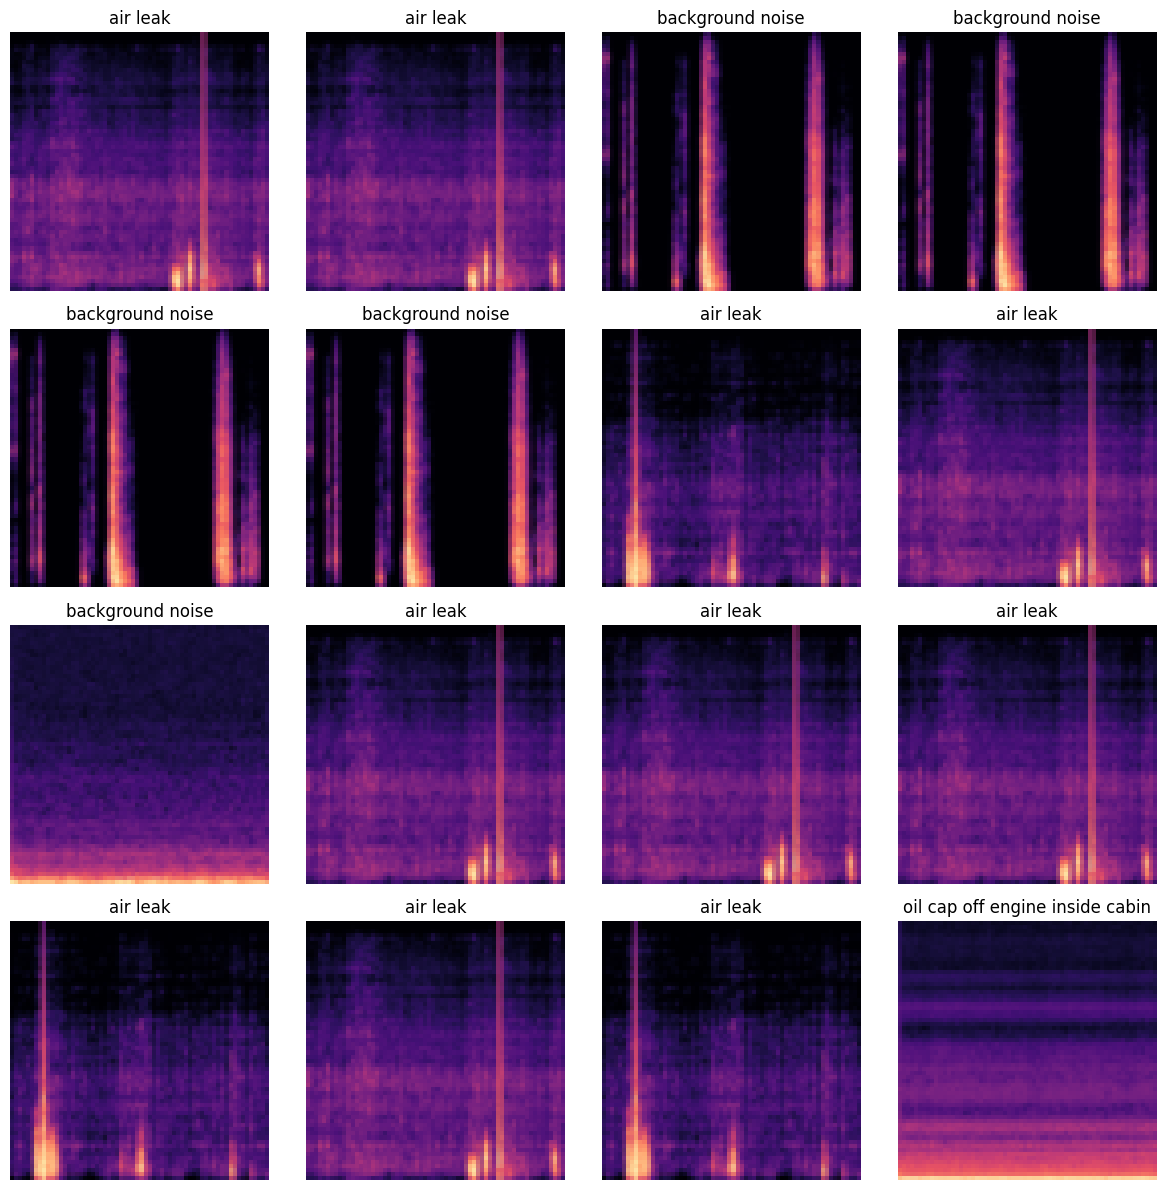

In [ ]:
imgs, feats, labels = next(iter(train_loader))

plt.figure(figsize=(12, 12)) # figure size 4x4 layout
for i in range(16):
    img_np = imgs[i].permute(1, 2, 0).numpy()
    label_str = le.inverse_transform([labels[i].item()])[0]
    plt.subplot(4, 4, i+1) # 4x4
    plt.imshow(img_np)
    plt.title(f"{label_str}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# STEP 6: CNN Ibrida

In [ ]:
class HybridCNNImproved(nn.Module):
    def __init__(self, num_classes):
        super(HybridCNNImproved, self).__init__()
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.feature_branch = nn.Sequential(
            nn.Linear(5, 32), nn.ReLU(), nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*8*8 + 32, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, img, feat):
        img_out = self.cnn_branch(img)
        feat_out = self.feature_branch(feat)
        combined = torch.cat((img_out, feat_out), dim=1)
        return self.classifier(combined)


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# ==== Early Stopping ====
class EarlyStopping:
    def __init__(self, patience=10, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# STEP 7: Setup

In [ ]:
print(f"label_encoded min: {df['label_encoded'].min()}, max: {df['label_encoded'].max()}")
print(f"Numero classi da LabelEncoder: {len(le.classes_)}")
print("Classi da LabelEncoder:", list(le.classes_))

label_encoded min: 0, max: 5
Numero classi da LabelEncoder: 6
Classi da LabelEncoder: ['air leak', 'air leak engine inside cabin', 'background noise', 'idling', 'normal engine inside cabin', 'oil cap off engine inside cabin']


In [ ]:
# Ricorda: le.label_encoded deve avere valori da 0 a 5
model = HybridCNNImproved(num_classes=len(le.classes_)).to(device)
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
early_stopper = EarlyStopping(patience=8)
EPOCHS =25

# STEP 8: Training

In [ ]:
train_acc, val_acc, test_acc = [], [], []
train_loss, val_loss, test_loss = [], [], []

for epoch in range(EPOCHS):
    # === TRAIN ===
    model.train()
    running_train_loss, correct_train, total_train = 0.0, 0, 0
    for imgs, feats, labels in train_loader:
        imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    train_acc.append(correct_train / total_train)
    train_loss.append(running_train_loss / total_train)

    # === VALIDATION ===
    model.eval()
    running_val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for imgs, feats, labels in val_loader:
            imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
            outputs = model(imgs, feats)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    val_acc.append(correct_val / total_val)
    val_loss.append(running_val_loss / total_val)

    # === TEST ===
    running_test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for imgs, feats, labels in test_loader:
            imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
            outputs = model(imgs, feats)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
    test_acc.append(correct_test / total_test)
    test_loss.append(running_test_loss / total_test)

    # === STAMPA ===
    print(f"Epoch {epoch+1:03d} | "
          f"Train Acc: {train_acc[-1]:.2f}, Loss: {train_loss[-1]:.4f} | "
          f"Val Acc: {val_acc[-1]:.2f}, Loss: {val_loss[-1]:.4f} | "
          f"Test Acc: {test_acc[-1]:.2f}, Loss: {test_loss[-1]:.4f}")

    # === EARLY STOPPING ===
    early_stopper(val_loss[-1], model)
    if early_stopper.early_stop:
        print("Early stopping triggered")
        break

# === ULTIMA STAMPA FINALE (dopo stop) ===
print(f"\n Final Test Accuracy: {test_acc[-1]:.2f} | Loss: {test_loss[-1]:.4f}")

Epoch 001 | Train Acc: 0.55, Loss: 0.7278 | Val Acc: 0.59, Loss: 1.1010 | Test Acc: 0.59, Loss: 1.1011
Epoch 002 | Train Acc: 0.71, Loss: 0.4296 | Val Acc: 0.59, Loss: 1.0403 | Test Acc: 0.59, Loss: 1.0404
Epoch 003 | Train Acc: 0.80, Loss: 0.3019 | Val Acc: 0.70, Loss: 1.0078 | Test Acc: 0.71, Loss: 1.0114
Epoch 004 | Train Acc: 0.83, Loss: 0.2677 | Val Acc: 0.70, Loss: 0.9050 | Test Acc: 0.71, Loss: 0.9150
Epoch 005 | Train Acc: 0.83, Loss: 0.2346 | Val Acc: 0.85, Loss: 0.7325 | Test Acc: 0.79, Loss: 0.7505
Epoch 006 | Train Acc: 0.94, Loss: 0.1628 | Val Acc: 0.89, Loss: 0.4922 | Test Acc: 0.88, Loss: 0.5240
Epoch 007 | Train Acc: 0.92, Loss: 0.1674 | Val Acc: 0.89, Loss: 0.2906 | Test Acc: 0.91, Loss: 0.3177
Epoch 008 | Train Acc: 0.96, Loss: 0.1622 | Val Acc: 0.89, Loss: 0.1944 | Test Acc: 0.91, Loss: 0.2067
Epoch 009 | Train Acc: 0.91, Loss: 0.1495 | Val Acc: 0.96, Loss: 0.1479 | Test Acc: 0.97, Loss: 0.1516
Epoch 010 | Train Acc: 0.95, Loss: 0.1084 | Val Acc: 0.96, Loss: 0.1265 |

# STEP 9: Report & Confusion Matrix


Classification Report:
                                 precision    recall  f1-score   support

                       air leak       1.00      1.00      1.00        20
   air leak engine inside cabin       1.00      1.00      1.00         1
               background noise       1.00      1.00      1.00         5
                         idling       1.00      1.00      1.00         1
     normal engine inside cabin       1.00      1.00      1.00         3
oil cap off engine inside cabin       1.00      1.00      1.00         4

                       accuracy                           1.00        34
                      macro avg       1.00      1.00      1.00        34
                   weighted avg       1.00      1.00      1.00        34



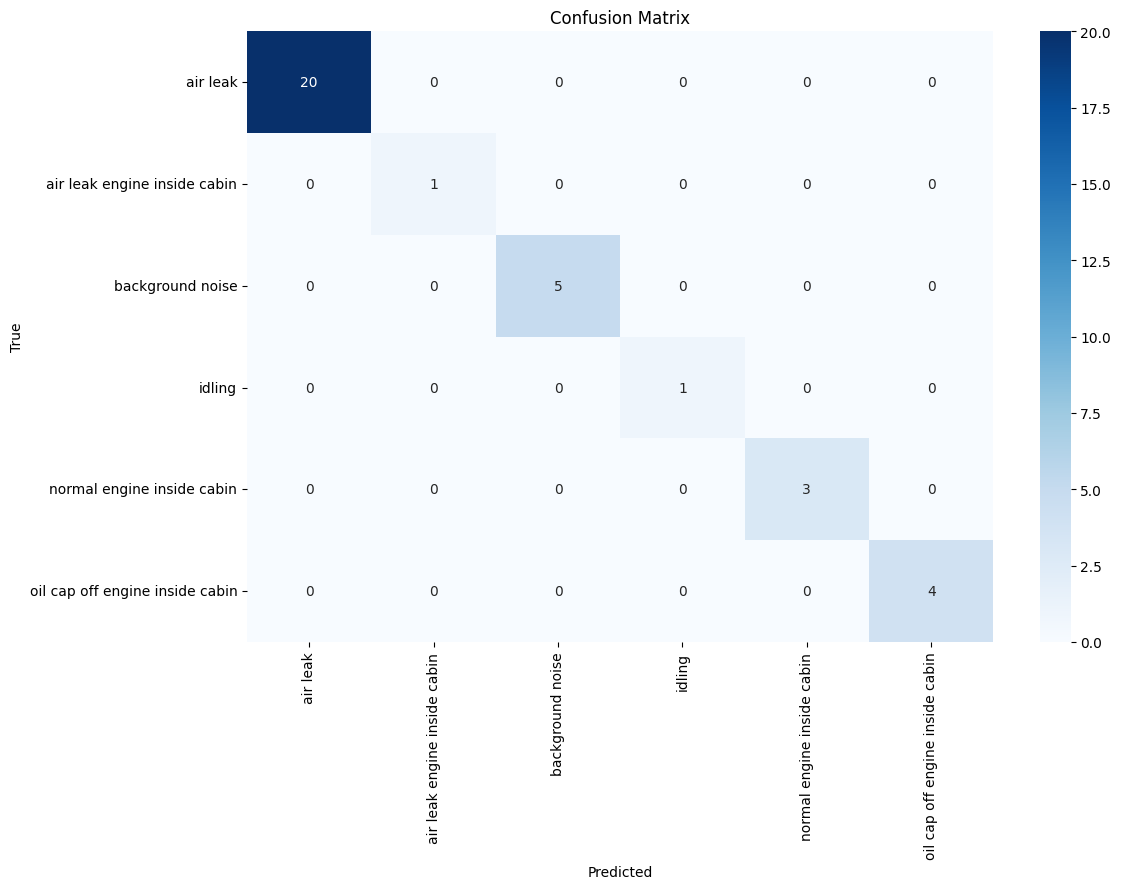

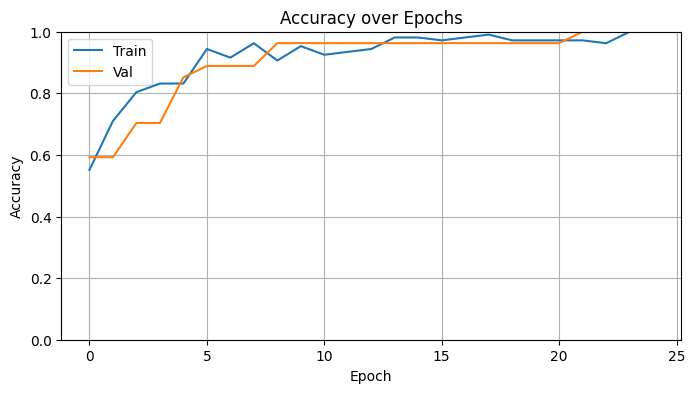

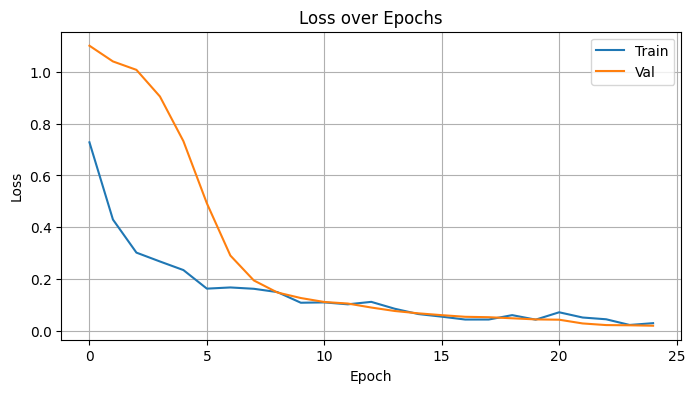

In [ ]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, feats, labels in test_loader:
        imgs, feats = imgs.to(device), feats.to(device)
        outputs = model(imgs, feats)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Get the unique labels present in the actual test set
unique_labels = np.unique(all_labels)
# Filter the target names to include only the unique labels present in the test set
target_names = [le.classes_[i] for i in unique_labels]

print("\nClassification Report:")
# Use the unique_labels for the classification report
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names, zero_division=0))

# Confusion Matrix
plt.figure(figsize=(12, 9))
# Use the unique_labels for the confusion matrix as well
sns.heatmap(confusion_matrix(all_labels, all_preds, labels=unique_labels), annot=True, fmt="d",
            cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/confusion_matrix_balanced.png")
plt.show()

# Accuracy
plt.figure(figsize=(8, 4))
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # <-- Limite corretto per accuracy
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# **CNN con Reverse**

In [ ]:
import os
import librosa
import pandas as pd
import numpy as np
import soundfile as sf
from pathlib import Path
from tqdm import tqdm

# === CONFIG ===
INPUT_DIR = "/content/drive/MyDrive/audio_segmented"
OUTPUT_DIR = "/content/drive/MyDrive/audio_reverse"
CSV_OUTPUT = "/content/drive/MyDrive/df_with_reverse.csv"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# estrazione feature audio
def extract_features(y, sr):
    try:
        pitch = librosa.yin(y, fmin=80, fmax=800, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        energy = np.mean(y ** 2)
        inst_freq = librosa.piptrack(y=y, sr=sr)[0]

        return {
            "pitch_mean": np.mean(pitch),
            "pitch_std": np.std(pitch),
            "energy": energy,
            "zcr_mean": np.mean(zcr),
            "instant_freq_mean": np.mean(inst_freq)
        }
    except Exception as e:
        print("Errore nelle feature:", e)
        return None

# costruzione del DataFrame
records = []

for fname in tqdm(os.listdir(INPUT_DIR), desc="Processamento"):
    if not fname.endswith(".wav"):
        continue

    label = fname.split("__")[0]
    audio_path = os.path.join(INPUT_DIR, fname)

    try:
        y, sr = librosa.load(audio_path, sr=None)
    except Exception as e:
        print(f"Errore caricamento {fname}: {e}")
        continue

    # -- Originale
    feats = extract_features(y, sr)
    if feats:
        records.append({
            "audio_path": audio_path,
            "label": label,
            **feats,
            "augmented": False
        })

    # -- Reverse
    try:
        y_rev = y[::-1]
        rev_name = fname.replace(".wav", "_rev.wav")
        rev_path = os.path.join(OUTPUT_DIR, rev_name)
        sf.write(rev_path, y_rev, sr)

        feats_rev = extract_features(y_rev, sr)
        if feats_rev:
            records.append({
                "audio_path": rev_path,
                "label": label,
                **feats_rev,
                "augmented": True
            })
    except Exception as e:
        print(f"Errore salvataggio o feature reverse per {fname}: {e}")

#Salva taggio CSV
df = pd.DataFrame(records)
df.to_csv(CSV_OUTPUT, index=False)

print(f"\nCSV salvato in: {CSV_OUTPUT}")
print(f"Totale righe: {len(df)}")
print(df.head())

Processamento: 100%|██████████| 223/223 [02:19<00:00,  1.60it/s]



CSV salvato in: /content/drive/MyDrive/df_with_reverse.csv
Totale righe: 446
                                          audio_path  \
0  /content/drive/MyDrive/audio_segmented/idling....   
1  /content/drive/MyDrive/audio_reverse/idling.2q...   
2  /content/drive/MyDrive/audio_segmented/idling....   
3  /content/drive/MyDrive/audio_reverse/idling.2q...   
4  /content/drive/MyDrive/audio_segmented/idling....   

                                               label  pitch_mean  pitch_std  \
0  idling.2qsiat0n.ingestion-5b6b8dfb4f-cqq49_seg...       800.0        0.0   
1  idling.2qsiat0n.ingestion-5b6b8dfb4f-cqq49_seg...       800.0        0.0   
2  idling.2qsiat0n.ingestion-5b6b8dfb4f-cqq49_seg...       800.0        0.0   
3  idling.2qsiat0n.ingestion-5b6b8dfb4f-cqq49_seg...       800.0        0.0   
4  idling.2qsiat0n.ingestion-5b6b8dfb4f-cqq49_seg...       800.0        0.0   

         energy  zcr_mean  instant_freq_mean  augmented  
0  5.960464e-08       0.0                0.0      Fa

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm

# === CONFIGURAZIONE ===
INPUT_AUDIO_DIR = "/content/drive/MyDrive/audio_reverse"
OUTPUT_PNG_DIR  = "/content/drive/MyDrive/audio_reverse/training_valid_audio_reverse"
WINDOW_DURATION = 0.5
STRIDE_DURATION = 0.5
MIN_AMPLITUDE = 0.01
MIN_DURATION = 0.5
# === CREA CARTELLE OUTPUT ===
Path(OUTPUT_PNG_DIR).mkdir(parents=True, exist_ok=True)

# === FUNZIONE: genera mel spettrogramma ===
def create_mel_spectrogram_from_array(y, sr, output_path):
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    fig = plt.figure(figsize=(0.72, 0.72))
    ax = fig.add_subplot(111)
    ax.axis('off')
    librosa.display.specshow(S_dB, sr=sr)
    plt.savefig(output_path, dpi=400, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

# === PROCESSO SLIDING WINDOW ===
audio_files = sorted([f for f in os.listdir(INPUT_AUDIO_DIR) if f.endswith(".wav")])
total_segments = 0
skipped_files = 0

for fname in tqdm(audio_files, desc="Sliding window da reverse"):
    audio_path = os.path.join(INPUT_AUDIO_DIR, fname)
    try:
        y, sr = librosa.load(audio_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)

        if duration < MIN_DURATION or np.max(np.abs(y)) < MIN_AMPLITUDE:
            skipped_files += 1
            continue

        samples_per_window = int(WINDOW_DURATION * sr)
        stride_samples = int(STRIDE_DURATION * sr)

        segment_index = 0
        for start in range(0, len(y) - samples_per_window + 1, stride_samples):
            segment = y[start:start + samples_per_window]
            if librosa.get_duration(y=segment, sr=sr) >= MIN_DURATION and np.max(np.abs(segment)) >= MIN_AMPLITUDE:
                base_name = fname.replace(".wav", f"_win{segment_index}")
                output_path = os.path.join(OUTPUT_PNG_DIR, base_name + ".png")
                create_mel_spectrogram_from_array(segment, sr, output_path)
                segment_index += 1
                total_segments += 1

    except Exception as e:
        print(f"[Errore su {fname}]: {e}")
        continue

# === RISULTATO FINALE ===
print(f"\n PNG generati generati: {total_segments}")
print(f"File  saltati (non validi): {skipped_files}")

Sliding window da reverse: 100%|██████████| 223/223 [06:58<00:00,  1.88s/it]


 PNG generati generati: 601
File  saltati (non validi): 125


In [ ]:
print(df.columns.tolist())

['audio_path', 'label', 'pitch_mean', 'pitch_std', 'energy', 'zcr_mean', 'instant_freq_mean', 'augmented']


In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler

# === CONFIG ===
csv_path = "/content/drive/MyDrive/features_combined_balanced_updated.csv"
SPECTROGRAM_DIR = "/content/drive/MyDrive/audio_reverse/training_valid_audio_reverse"

# Caricamento CSV con le features
df = pd.read_csv(csv_path)

# mappa label - ricostruxzione
label_map = dict(zip(df["label_encoded"], df["label"]))
records = []
all_pngs = os.listdir(SPECTROGRAM_DIR)

# Cerca i file *_segX_rev.png per ogni base audio
for _, row in df.iterrows():
    row_dict = row.to_dict()
    base_name = os.path.basename(row_dict["audio_path"]).replace(".wav", "")

    # Cerca match flessibile tipo: [base_name]_segX_rev.png
    matches = [f for f in all_pngs if f.startswith(base_name) and f.endswith("_rev.png")]

    for match in matches:
        rev_png_path = os.path.join(SPECTROGRAM_DIR, match)
        record = {
            "audio_path": row_dict["audio_path"],
            "spectrogram_path": rev_png_path,
            "label_encoded": row_dict["label_encoded"],
            "label": label_map[row_dict["label_encoded"]],
            "pitch_mean": row_dict["pitch_mean"],
            "pitch_std": row_dict["pitch_std"],
            "energy": row_dict["energy"],
            "zcr_mean": row_dict["zcr_mean"],
            "instant_freq_mean": row_dict["instant_freq_mean"]
        }
        records.append(record)

# DataFrame aggiornato
df_new = pd.DataFrame(records)

# Normalizzazione
features = ["pitch_mean", "pitch_std", "energy", "zcr_mean", "instant_freq_mean"]
if not df_new.empty:
    df_new[features] = StandardScaler().fit_transform(df_new[features])

#  Salvaraggio CSV
output_path = "/content/drive/MyDrive/features_combined_balanced_Reverse.csv"
df_new.to_csv(output_path, index=False)

print(f"CSV aggiornato salvato in: {output_path}")
print(f"Righe finali: {len(df_new)}")

CSV aggiornato salvato in: /content/drive/MyDrive/features_combined_balanced_Reverse.csv
Righe finali: 2632


In [ ]:
import pandas as pd

# === Percorsi CSV ===
csv_normale = "/content/drive/MyDrive/features_combined_balanced_updated.csv"
csv_reverse = "/content/drive/MyDrive/features_combined_balanced_Reverse.csv"

# caricamento
df_norm = pd.read_csv(csv_normale)
df_rev = pd.read_csv(csv_reverse)

# aggiunta colonna 'augmentation_type'
df_norm["augmentation_type"] = "original"
df_rev["augmentation_type"] = "reverse"

# Verifica delle colonne compatibili (solo quelle rilevanti)
common_cols = ['audio_path', 'spectrogram_path', 'label', 'pitch_mean', 'pitch_std',
               'energy', 'zcr_mean', 'instant_freq_mean', 'label_encoded', 'augmentation_type']

df_norm = df_norm[common_cols]
df_rev = df_rev[common_cols]

# Unisco
df_all = pd.concat([df_norm, df_rev], ignore_index=True)

# Salvataggio
final_path = "/content/drive/MyDrive/features_combined_balanced_final.csv"
df_all.to_csv(final_path, index=False)

print(f" Dataset completo salvato in: {final_path}")
print(f"Totale righe: {len(df_all)}")
print(df_all["augmentation_type"].value_counts())

 Dataset completo salvato in: /content/drive/MyDrive/features_combined_balanced_final.csv
Totale righe: 2800
augmentation_type
reverse     2632
original     168
Name: count, dtype: int64


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label_encoded']),
    y=df['label_encoded']
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# Split

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder

csv_path = "/content/drive/MyDrive/features_combined_balanced_final.csv"

# Caricamento dataset
full_df = pd.read_csv(csv_path)

# Fit LabelEncoder on the full dataset BEFORE splitting
le = LabelEncoder()
full_df['label_encoded'] = le.fit_transform(full_df['label'])

# Split stratificato
train_df, temp_df = train_test_split(full_df, test_size=0.3, stratify=full_df['label_encoded'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label_encoded'], random_state=42)

# Salvataggio CSV temporanei
train_df.to_csv("/content/train.csv", index=False)
val_df.to_csv("/content/val.csv", index=False)
test_df.to_csv("/content/test.csv", index=False)

print(" Data split complete. Fitted LabelEncoder on the full dataset.")
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

 Data split complete. Fitted LabelEncoder on the full dataset.
Train: 1960, Val: 420, Test: 420


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd

# Caricamento CSV in DataFrame
df_train = pd.read_csv("/content/train.csv")
df_val   = pd.read_csv("/content/val.csv")
df_test  = pd.read_csv("/content/test.csv")

# Trasformazioni per le immagini
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Creaxzione dei Dataset
train_ds = HybridAudioDataset(df_train, transform=transform)
val_ds   = HybridAudioDataset(df_val, transform=transform)
test_ds  = HybridAudioDataset(df_test, transform=transform)

# Creazione dei DataLoader
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False)

print("DataLoader creati con successo.")

DataLoader creati con successo.


In [ ]:
img, feat, label = next(iter(train_loader))
print(f"Immagine: {img.shape}")         # torch.Size([batch, 3, 64, 64])
print(f" Feature: {feat.shape}")        # torch.Size([batch, 5])
print(f"Label: {label.shape}")         # torch.Size([batch])

Immagine: torch.Size([16, 3, 64, 64])
 Feature: torch.Size([16, 5])
Label: torch.Size([16])


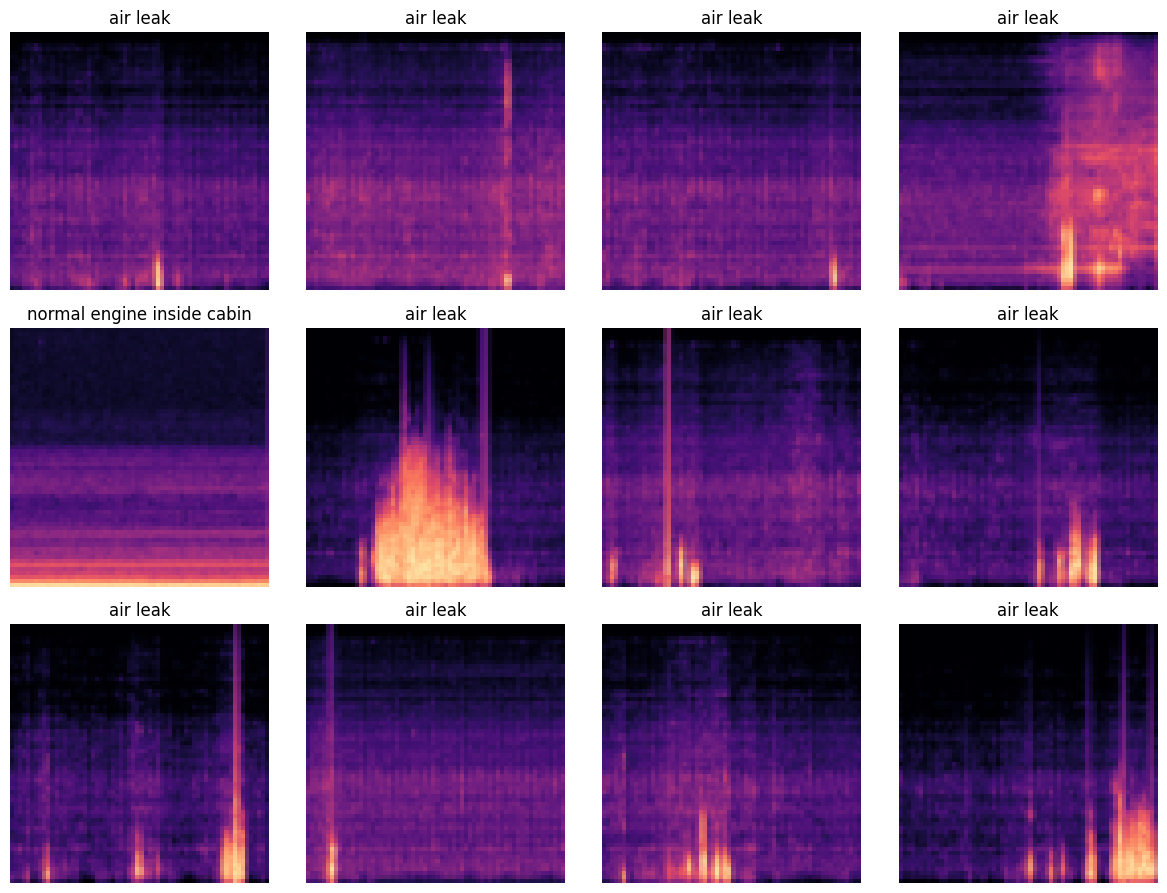

In [ ]:
imgs, feats, labels = next(iter(train_loader))

plt.figure(figsize=(12, 12)) # 4x4 layout
for i in range(12):
    img_np = imgs[i].permute(1, 2, 0).numpy()
    label_str = le.inverse_transform([labels[i].item()])[0]
    plt.subplot(4, 4, i+1) # 4x4
    plt.imshow(img_np)
    plt.title(f"{label_str}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
class HybridCNNImproved(nn.Module):
    def __init__(self, num_classes):
        super(HybridCNNImproved, self).__init__()
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.feature_branch = nn.Sequential(
            nn.Linear(5, 32), nn.ReLU(), nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*8*8 + 32, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, img, feat):
        img_out = self.cnn_branch(img)
        feat_out = self.feature_branch(feat)
        combined = torch.cat((img_out, feat_out), dim=1)
        return self.classifier(combined)



In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# ==== Early Stopping ====
class EarlyStopping:
    def __init__(self, patience=10, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True



In [ ]:
print(f"label_encoded min: {df['label_encoded'].min()}, max: {df['label_encoded'].max()}")
print(f"Numero classi da LabelEncoder: {len(le.classes_)}")
print("Classi da LabelEncoder:", list(le.classes_))



label_encoded min: 0, max: 5
Numero classi da LabelEncoder: 6
Classi da LabelEncoder: ['air leak', 'air leak engine inside cabin', 'background noise', 'idling', 'normal engine inside cabin', 'oil cap off engine inside cabin']


In [ ]:
model = HybridCNNImproved(num_classes=len(le.classes_)).to(device)
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
early_stopper = EarlyStopping(patience=8)
EPOCHS = 10

In [ ]:
train_acc, val_acc, test_acc = [], [], []
train_loss, val_loss, test_loss = [], [], []

for epoch in range(EPOCHS):
    # === TRAIN ===
    model.train()
    running_train_loss, correct_train, total_train = 0.0, 0, 0
    for imgs, feats, labels in train_loader:
        imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    train_acc.append(correct_train / total_train)
    train_loss.append(running_train_loss / total_train)

    # === VALIDATION ===
    model.eval()
    running_val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for imgs, feats, labels in val_loader:
            imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
            outputs = model(imgs, feats)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    val_acc.append(correct_val / total_val)
    val_loss.append(running_val_loss / total_val)

    # === TEST ===
    running_test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for imgs, feats, labels in test_loader:
            imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
            outputs = model(imgs, feats)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
    test_acc.append(correct_test / total_test)
    test_loss.append(running_test_loss / total_test)

    # === STAMPA ===
    print(f"Epoch {epoch+1:03d} | "
          f"Train Acc: {train_acc[-1]:.2f}, Loss: {train_loss[-1]:.4f} | "
          f"Val Acc: {val_acc[-1]:.2f}, Loss: {val_loss[-1]:.4f} | "
          f"Test Acc: {test_acc[-1]:.2f}, Loss: {test_loss[-1]:.4f}")

    # === EARLY STOPPING ===
    early_stopper(val_loss[-1], model)
    if early_stopper.early_stop:
        print("Early stopping triggered")
        break

# === ULTIMA STAMPA FINALE (dopo stop) ===
print(f"\n Final Test Accuracy: {test_acc[-1]:.2f} | Loss: {test_loss[-1]:.4f}")


Epoch 001 | Train Acc: 0.93, Loss: 0.1554 | Val Acc: 0.98, Loss: 0.0475 | Test Acc: 0.98, Loss: 0.0398
Epoch 002 | Train Acc: 0.98, Loss: 0.0395 | Val Acc: 0.99, Loss: 0.0218 | Test Acc: 0.98, Loss: 0.0219
Epoch 003 | Train Acc: 0.99, Loss: 0.0228 | Val Acc: 1.00, Loss: 0.0129 | Test Acc: 0.99, Loss: 0.0154
Epoch 004 | Train Acc: 0.99, Loss: 0.0149 | Val Acc: 1.00, Loss: 0.0086 | Test Acc: 1.00, Loss: 0.0095
Epoch 005 | Train Acc: 0.99, Loss: 0.0111 | Val Acc: 1.00, Loss: 0.0049 | Test Acc: 1.00, Loss: 0.0061
Epoch 006 | Train Acc: 0.99, Loss: 0.0110 | Val Acc: 1.00, Loss: 0.0046 | Test Acc: 1.00, Loss: 0.0063
Epoch 007 | Train Acc: 1.00, Loss: 0.0074 | Val Acc: 1.00, Loss: 0.0023 | Test Acc: 1.00, Loss: 0.0028
Epoch 008 | Train Acc: 1.00, Loss: 0.0061 | Val Acc: 1.00, Loss: 0.0016 | Test Acc: 1.00, Loss: 0.0021
Epoch 009 | Train Acc: 1.00, Loss: 0.0058 | Val Acc: 1.00, Loss: 0.0012 | Test Acc: 1.00, Loss: 0.0014
Epoch 010 | Train Acc: 1.00, Loss: 0.0041 | Val Acc: 1.00, Loss: 0.0005 |


 Classification Report:
                                 precision    recall  f1-score   support

                       air leak       1.00      1.00      1.00       375
   air leak engine inside cabin       1.00      1.00      1.00         2
               background noise       1.00      1.00      1.00        24
                         idling       1.00      1.00      1.00         3
     normal engine inside cabin       1.00      1.00      1.00         7
oil cap off engine inside cabin       1.00      1.00      1.00         9

                       accuracy                           1.00       420
                      macro avg       1.00      1.00      1.00       420
                   weighted avg       1.00      1.00      1.00       420



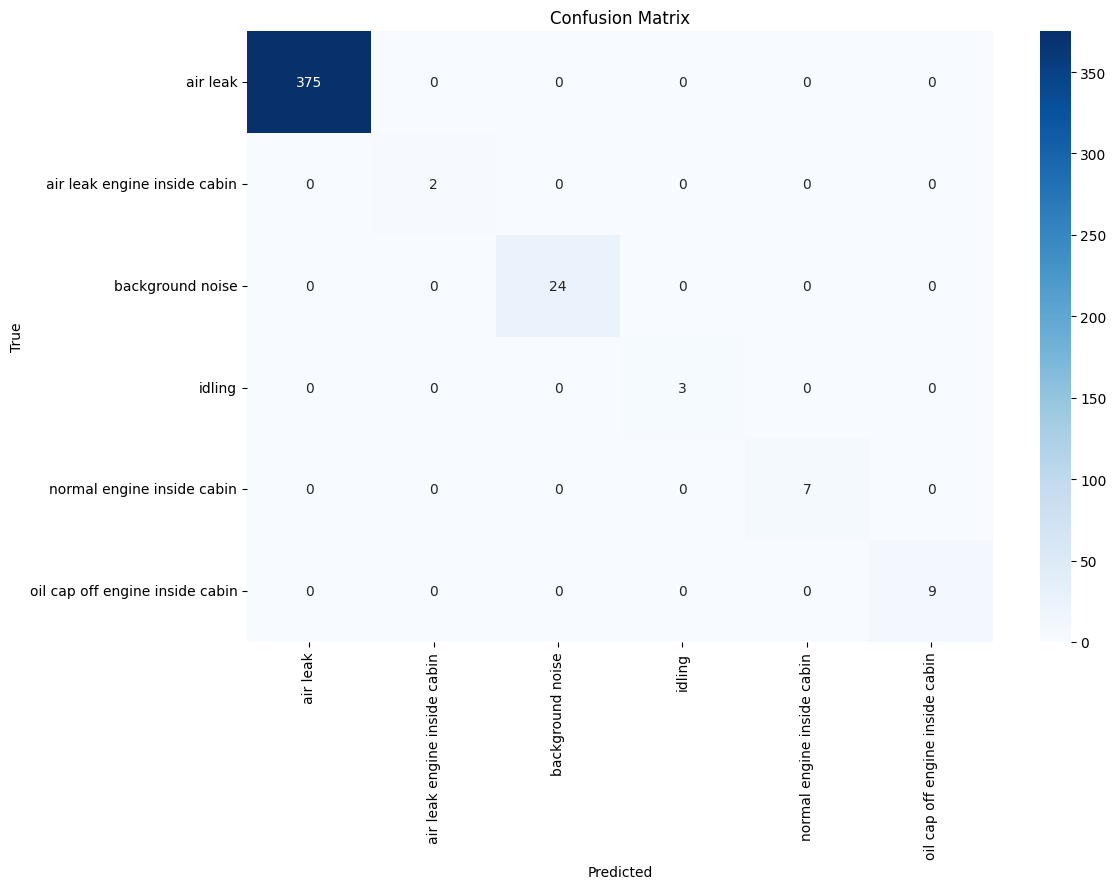

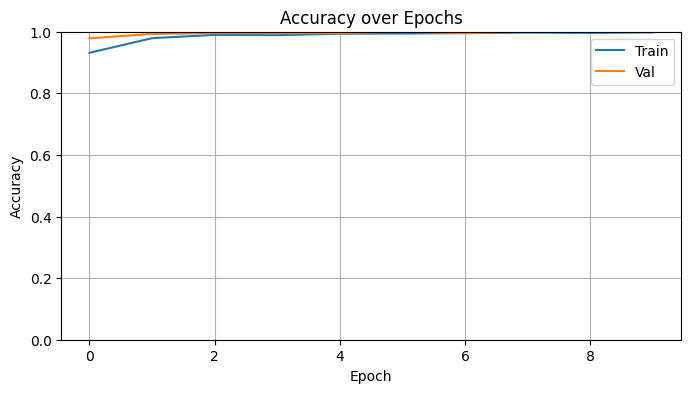

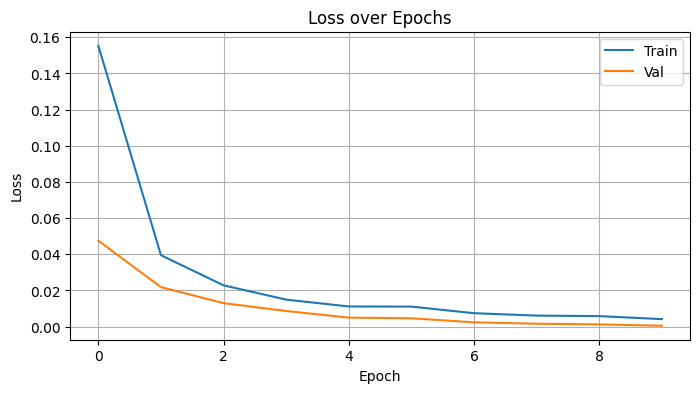

In [ ]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, feats, labels in test_loader:
        imgs, feats = imgs.to(device), feats.to(device)
        outputs = model(imgs, feats)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Get the unique labels present in the actual test set
unique_labels = np.unique(all_labels)
# Filter the target names to include only the unique labels present in the test set
target_names = [le.classes_[i] for i in unique_labels]

print("\n Classification Report:")
# Use the unique_labels for the classification report
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names, zero_division=0))

# Confusion Matrix
plt.figure(figsize=(12, 9))
# Use the unique_labels for the confusion matrix as well
sns.heatmap(confusion_matrix(all_labels, all_preds, labels=unique_labels), annot=True, fmt="d",
            cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/confusion_matrix_balanced_rev.png")
plt.show()

# Accuracy
plt.figure(figsize=(8, 4))
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # <-- Limite corretto per accuracy
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

##  Modello ResNetHybrid

In [ ]:
from torchvision import models
import torch.nn as nn

class ResNetHybrid(nn.Module):
    def __init__(self, num_classes):
        super(ResNetHybrid, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # rimozione classificatore finale
        self.feature_branch = nn.Sequential(nn.Linear(5, 64), nn.ReLU())
        self.classifier = nn.Sequential(
            nn.Linear(512 + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, img, feat):
        img_out = self.backbone(img)
        feat_out = self.feature_branch(feat)
        combined = torch.cat((img_out, feat_out), dim=1)
        return self.classifier(combined)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

class EarlyStopping:
    def __init__(self, patience=10, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetHybrid(num_classes=len(le.classes_)).to(device)
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopping(patience=8)

EPOCHS = 100
train_acc, val_acc, train_loss, val_loss = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, feats, labels in train_loader:
        imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc.append(correct / total)
    train_loss.append(running_loss / total)

    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, feats, labels in test_loader:
            imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
            outputs = model(imgs, feats)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc.append(correct / total)
    val_loss.append(running_loss / total)

    print(f"Epoch {epoch+1:03d} | "
          f"Train Acc: {train_acc[-1]:.2f}, Loss: {train_loss[-1]:.4f} | "
          f"Val Acc: {val_acc[-1]:.2f}, Loss: {val_loss[-1]:.4f}")

    early_stopper(val_loss[-1], model)
    if early_stopper.early_stop:
        print("Early stopping triggered")
        break

# Caricamento del best model
model.load_state_dict(early_stopper.best_model)
print("Best model loaded.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


Epoch 001 | Train Acc: 0.94, Loss: 0.1004 | Val Acc: 0.97, Loss: 0.0424
Epoch 002 | Train Acc: 0.97, Loss: 0.0399 | Val Acc: 0.97, Loss: 0.0406
Epoch 003 | Train Acc: 0.97, Loss: 0.0228 | Val Acc: 0.98, Loss: 0.0189
Epoch 004 | Train Acc: 0.98, Loss: 0.0214 | Val Acc: 0.97, Loss: 0.0190
Epoch 005 | Train Acc: 0.97, Loss: 0.0652 | Val Acc: 0.97, Loss: 0.0266
Epoch 006 | Train Acc: 0.98, Loss: 0.0253 | Val Acc: 0.98, Loss: 0.0174
Epoch 007 | Train Acc: 0.98, Loss: 0.0166 | Val Acc: 0.98, Loss: 0.0198
Epoch 008 | Train Acc: 0.99, Loss: 0.0156 | Val Acc: 0.98, Loss: 0.0130
Epoch 009 | Train Acc: 0.99, Loss: 0.0120 | Val Acc: 0.99, Loss: 0.0112
Epoch 010 | Train Acc: 0.99, Loss: 0.0106 | Val Acc: 0.98, Loss: 0.0148
Epoch 011 | Train Acc: 0.99, Loss: 0.0126 | Val Acc: 1.00, Loss: 0.0058
Epoch 012 | Train Acc: 0.99, Loss: 0.0059 | Val Acc: 0.97, Loss: 0.0633
Epoch 013 | Train Acc: 0.97, Loss: 0.0654 | Val Acc: 0.98, Loss: 0.0095
Epoch 014 | Train Acc: 0.99, Loss: 0.0156 | Val Acc: 0.98, Loss:

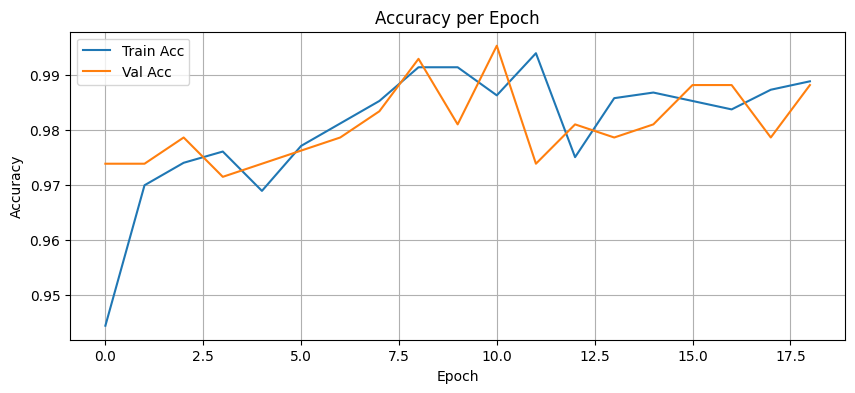

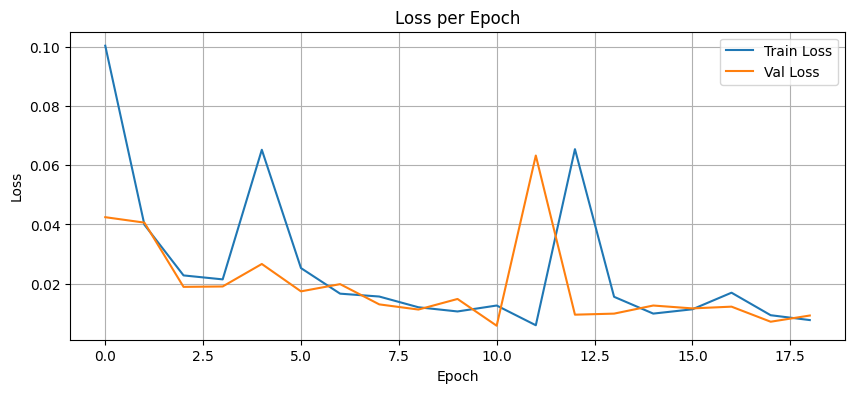

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(10, 4))
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

 Classification Report:

                                 precision    recall  f1-score   support

                       air leak       1.00      1.00      1.00       375
   air leak engine inside cabin       1.00      1.00      1.00         2
               background noise       1.00      1.00      1.00        24
                         idling       1.00      1.00      1.00         3
     normal engine inside cabin       1.00      0.29      0.44         7
oil cap off engine inside cabin       0.64      1.00      0.78         9

                       accuracy                           0.99       420
                      macro avg       0.94      0.88      0.87       420
                   weighted avg       0.99      0.99      0.99       420



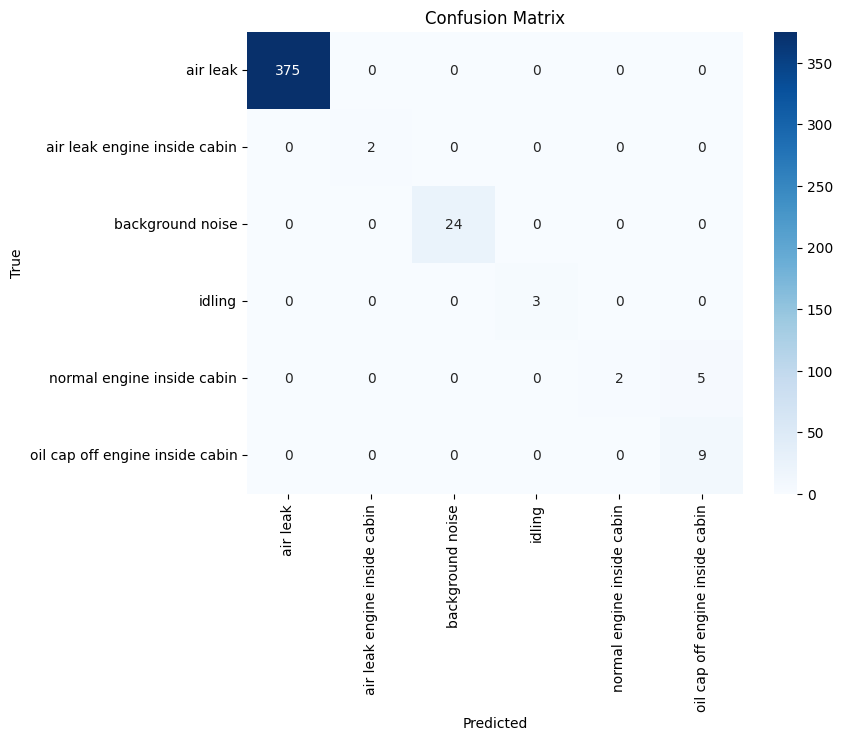

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Previsioni sul test set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, feats, labels in test_loader:
        imgs, feats = imgs.to(device), feats.to(device)
        outputs = model(imgs, feats)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Get the unique labels present in the actual test set
unique_labels = np.unique(all_labels)
# Filter the target names to include only the unique labels present in the test set
target_names = [le.classes_[i] for i in unique_labels]

# Classification report
print(" Classification Report:\n")
# Use the unique_labels for the classification report
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names, zero_division=0))

# Confusion matrix
plt.figure(figsize=(8, 6))
# Use the unique_labels for the confusion matrix as well
sns.heatmap(confusion_matrix(all_labels, all_preds, labels=unique_labels), annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()